<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Juypter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Chemical modelling: Dissolution and dissociation of carbon dioxide
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we discuss the **dissolution and dissociation of carbon dioxide**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import geodyn_div;geodyn_div.change_fonts()

In [2]:
R        = 8.314   # Gas constant, Pa m3 / K / mol
atm2Pa   = 101325. # 1 atm = 101325 Pa
liter2m3 = 1.e-3   # 1 l   = 1000 cm3 = 10^-3 m3 
year2sec = 365*24*60*60
day2sec  = 24*60*60
min2sec  = 60
tiny     = 1e-20

----
## Dissociation of water
$$
\mbox{H}_2\mbox{O} 
\overset{k_d}{\underset{k_a}{\leftrightarrow}} 
\mbox{H}^+ + \mbox{OH}^-
$$

The dissociation of water is a fairly fast process, and usually in equalibrium, described by
the **equilibrium constant** $K_W$ [mol$^2$/l$^2$/s]:
$$
K_W = \frac{k_d}{k_a} = 
\frac{(\mbox{H}^+)(\mbox{OH}^-)}{(\mbox{H}_2\mbox{O})} 
\simeq (\mbox{H}^+)(\mbox{OH}^-)
$$
In the last step, we sssume that water is abundant and concentration (activity) des not change.

From measured $K_W$ (e.g., Millero et al., 1979) and measured $k_a$ (e.g. Eigen et al., 1958, after
Stillinger, 1978), we can calculate $k_d$:
$$
k_d = k_a K_W
$$

In [3]:
def KW(TC,S=0):
    """
    -----------------------------------------------------------------------
    KW - equilibrium constant dissociation of water
    H2O <-> H+ + OH-
    from:
    Millero, Geochemica et Cosmochemica Acta 43:1651-1661, 1979
    refit data of Harned and Owen, The Physical Chemistry of
    Electrolyte Solutions, 1958
    this is on the SWS pH scale in (mol/kg-SW)^2
    input: 
    TC [C]         - temperature
    S [permil]     - salinity
    output:
    KW [mol^2/l^2] - H2O <-> H+ + OH-
    -----------------------------------------------------------------------
    """
    TK = 273.16 + TC
    KW = 148.9802 - 13847.26/TK - 23.6521*np.log(TK)
    KW = np.exp(KW)
    return KW

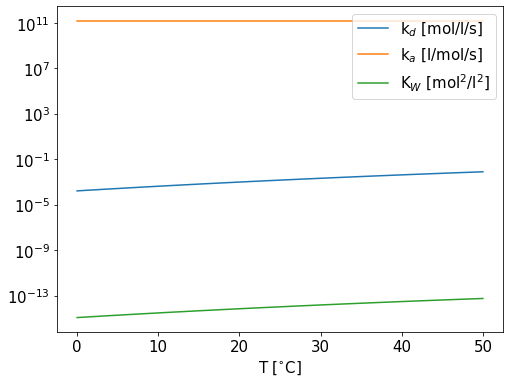

In [4]:
TC = np.linspace(0,50,51)
ka = 1.4e11*np.ones(TC.shape[0]) # l/mol/s
kd = ka*KW(TC)                   # mol/l/s

plt.figure(figsize=(8,6))
plt.xlabel('T [$^{\circ}$C]')
plt.semilogy(TC,kd,label='k$_d$ [mol/l/s]')
plt.semilogy(TC,ka,label='k$_a$ [l/mol/s]')
plt.semilogy(TC,KW(TC),label='K$_W$ [mol$^2$/l$^2$]')
plt.legend()
plt.savefig('figures/CHEM_KW_kd_ka')

----
## Dissolution of CO$_2$ in water -part 1-
For pH$<8$, the dominant reaction is:
$$
\mbox{CO}_2 + \mbox{H}_2\mbox{O}
\overset{k_1^+}{\underset{k_1^-}{\leftrightarrow}} 
\mbox{H}^+ + \mbox{HCO}_3^-
$$

If the reaction is in equilibrium, we can define an **equilibrium constant** $K_1$ [mol/l] as:
$$
K_1 = \frac{k_1^+}{k_1^-} = \frac{(\mbox{H}^+)(\mbox{HCO}_3^-)}{(\mbox{CO}_2)}
$$
Again, we have assumed water is plenty.

From measured $K_1$ (e.g., Millero et al., 2006) and measured $k_1^+$ 
(e.g., Johnsson, 1982, after Schulz et al, 2006), we can calculate $k_1^-$:
$$
k_1^- = \frac{k_1^+}{K_1}
$$

In [5]:
def K0K1K2K5(TC):
    """
    -----------------------------------------------------------------------
     K_1 and K_2 (my old version)
    -----------------------------------------------------------------------
    ! pure water
    ! Millero, F. J., Geochemica et Cosmochemica Acta 43:1651-1661, 1979:
    ! K1 from refit data from Harned and Davis,
    ! J American Chemical Society, 65:2030-2037, 1943.
    ! K2 from refit data from Harned and Scholes,
    ! J American Chemical Society, 43:1706-1709, 1941.
    ! This is only to be used for Sal=0 water (note the absence of S in the below formulations)
    ! These are the thermodynamic Constants:
    ! this is on the SWS pH scale in mol/kg-SW
    """
    TK = 273.16 + TC
    K1 = 290.9097 - 14554.21/TK - 45.0575*np.log(TK)
    K1 = np.exp(K1)
    K2 = 207.6548 - 11843.79/TK - 33.6485*np.log(TK)
    K2 = np.exp(K2)
    K5 = 1.707e-4
    K0 = K5 / K1
    return K0,K1,K2,K5

In [6]:
def K1K2(TC,S=0):
    """
    -----------------------------------------------------------------------
    K_1 and K_2 equilibrium constants dissociation of CO2 in water
    K1: CO2 + H2O <-> H+ + HCO3- 
    K2: HCO3-     <-> H+ + CO3--
    
    from:
    Millero et al (2006):
    Dissociation constants of carbonic acid in seawater as a function of 
    salinity and temperature, Marine Chemistry 100(1-2):80-94.
    input:
    TC [C]         - temperature
    S [permil]     - salinity
    output:
    K1 [mol/l]     - K1 = (H+)(HCO3-) / (CO2)
    K2 [mol/l]     - K2 = (H+)(CO3--) / (HCO3-)
    -----------------------------------------------------------------------
    """
    TK  = 273.16 + TC
    pK1 = -126.34048 + 6320.813/TK + 19.568224*np.log(TK)
    K1  = 10**(-pK1)
    pK2 = -90.18333 + 5143.692/TK + 14.613358*np.log(TK)
    K2  = 10**(-pK2)
    return K1,K2

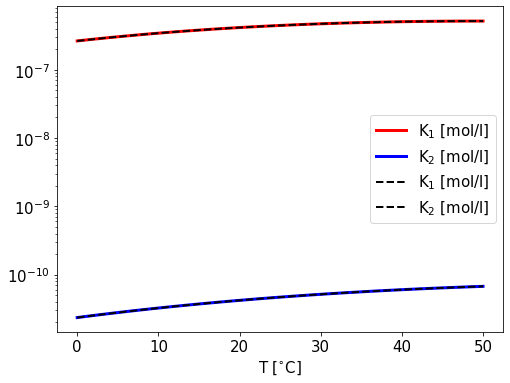

In [7]:
plt.figure(figsize=(8,6))
plt.xlabel('T [$^{\circ}$C]')
plt.semilogy(TC,K1K2(TC)[0],linewidth=3,color='red',linestyle='solid',label='K$_1$ [mol/l]')
plt.semilogy(TC,K1K2(TC)[1],linewidth=3,color='blue',linestyle='solid',label='K$_2$ [mol/l]')

plt.semilogy(TC,K0K1K2K5(TC)[1],linewidth=2,color='black',linestyle='dashed',label='K$_1$ [mol/l]')
plt.semilogy(TC,K0K1K2K5(TC)[2],linewidth=2,color='black',linestyle='dashed',label='K$_2$ [mol/l]')
plt.legend()

In [8]:
def k1pk1m(TC,S=0):
    """
    -----------------------------------------------------------------------
    k1-,k1-  - dissociation of CO2 in water
    CO2 + H2O <-> H+ + HCO3-
    -----------------------------------------------------------------------
    Johnsson (1982), after Schulz et al (2006): Determination of the rate 
    constants for the carbon dioxide to bicarbonate inter-conversion in 
    pH-buffered seawater systems, Mar. Chem., 100, 53-65
    input:
    TC [C]         - temperature
    S [permil]     - salinity
    output:
    k1+ [1/s]      - (CO2)+(H2O) -> (H+) + (HCO3-)
    k1- [mol/l/s]  - (CO2)+(H2O) <- (H+) + (HCO3-)
    k1- calculated from k1p/K1
    """
    TK = 273.16 + TC
    k1p = np.exp(1246.98 - 6.19e4/TK - 183.0*np.log(TK))
    k1m = k1p/K1K2(TC)[0]
    return k1p,k1m

print('k1p(25C)= ',k1pk1m(25)[0])
print('k1m(25C)= ',k1pk1m(25)[1])

k1p(25C)=  0.03714259548361576
k1m(25C)=  83425.15112254568


k1p(25C)=  0.03714259548361576
k1m(25C)=  83425.15112254568


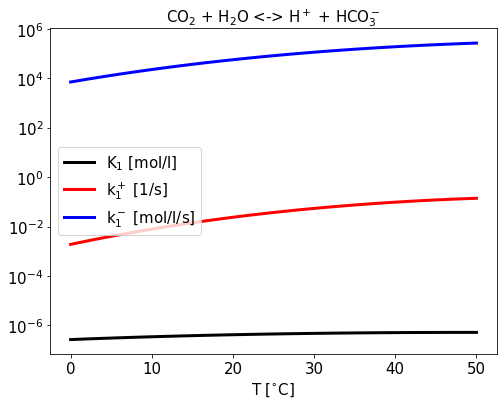

In [9]:
plt.figure(figsize=(8,6))
plt.title('CO$_2$ + H$_2$O <-> H$^+$ + HCO$_3^-$')
plt.xlabel('T [$^{\circ}$C]')
plt.semilogy(TC,K1K2(TC)[0],linewidth=3,color='black',linestyle='solid',label='K$_1$ [mol/l]')
plt.semilogy(TC,k1pk1m(TC)[0],linewidth=3,color='red',linestyle='solid',label='k$_1^+$ [1/s]')
plt.semilogy(TC,k1pk1m(TC)[1],linewidth=3,color='blue',linestyle='solid',label='k$_1^-$ [mol/l/s]')
plt.legend()
plt.savefig('figures/CHEM_K1_k1p_k1m')

print('k1p(25C)= ',k1pk1m(25)[0])
print('k1m(25C)= ',k1pk1m(25)[1])

----
## Dissolution of CO$_2$ in water -part 2-
For pH$>8$, another reaction becomes dominant:
$$
\mbox{CO}_2 + \mbox{OH}^-
\overset{k_4^+}{\underset{k_4^-}{\leftrightarrow}} 
\mbox{HCO}_3^-
$$
If the reaction is in equilibrium, we can define an **equilibrium constant** $K_2$ [mol/l] as:
$$
\frac{K_1}{K_W} = \frac{k_4^+}{k_4^-} = \frac{(\mbox{H}^+)(\mbox{CO}_3^{2-})}{(\mbox{HCO}_3^-)}
$$

From measured $K_W$ (e.g., Millero et al., 1979), 
measured $K_1$ (e.g., Millero et al., 2006) and measured $k_4^+$ 
(e.g., Johnsson, 1982, after Schulz et al, 2006), we can calculate $k_4^-$:
$$
k_4^- = k_4^+ \frac{K_W}{K_1}
$$
But $k_4^-$ has also been measured (e.g., Johnsson, 1982, after Schulz et al, 2006) ...

In [10]:
def k4pk4m(TC,S=0):
    """
    -----------------------------------------------------------------------
    k4-,k4-  - dissolution of CO2 in OH-
    HCO3- <-> H+ + CO3--
    -----------------------------------------------------------------------
    Johnsson (1982), after Schulz et al (2006): Determination of the rate 
    constants for the carbon dioxide to bicarbonate inter-conversion in 
    pH-buffered seawater systems, Mar. Chem., 100, 53-65 
    input:
    TC [C]         - temperature
    S [permil]     - salinity
    output:
    k4+ [l/mol/s]  - (CO2)+(OH-) -> (HCO3-)
    k4- [1/s]      - (CO2)+(OH-) <- (HCO3-)
    k4- calculated from k1p/K1
    alternative for k4- from equilibrium: k4- = k4+*KW/K1
    """
    TK = 273.16 + TC
    A = -930.13; B = 0.110; D = 3.10e4; E = 140.9
    k4p = A + B*S*0.5 + D/TK + E*np.log(TK)
    k4p = np.exp(k4p) / KW(TC)
    A = -2225.22; B = -0.049; D = 8.91e4; E = 336.6
    k4m = A + B*S*0.5 + D/TK + E*np.log(TK)
    k4m = np.exp(k4m)
    return k4p,k4m

print('k4p(25C)= ',k4pk4m(25)[0])
print('k4m(25C)= ',k4pk4m(25)[1])

k4p(25C)=  7046.072948913183
k4m(25C)=  0.0001906989250918436


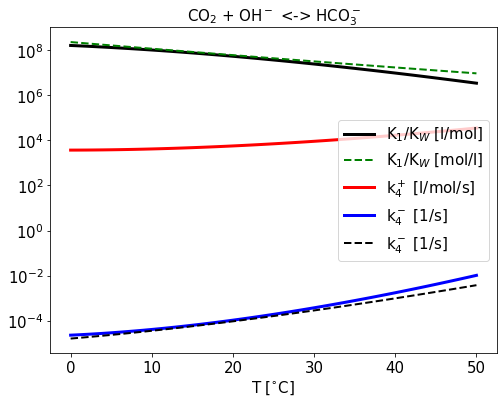

In [11]:
plt.figure(figsize=(8,6))
plt.title('CO$_2$ + OH$^-$ <-> HCO$_3^-$')
plt.xlabel('T [$^{\circ}$C]')
plt.semilogy(TC,k4pk4m(TC)[0]/k4pk4m(TC)[1],linewidth=3,color='black',linestyle='solid',label='K$_1$/K$_W$ [l/mol]')
plt.semilogy(TC,K1K2(TC)[0]/KW(TC),linewidth=2,color='green',linestyle='dashed',label='K$_1$/K$_W$ [mol/l]')
plt.semilogy(TC,k4pk4m(TC)[0],linewidth=3,color='red',linestyle='solid',label='k$_4^+$ [l/mol/s]')
plt.semilogy(TC,k4pk4m(TC)[1],linewidth=3,color='blue',linestyle='solid',label='k$_4^-$ [1/s]')
plt.semilogy(TC,k4pk4m(TC)[0]*KW(TC)/K1K2(TC)[0],linewidth=2,color='black',linestyle='dashed',label='k$_4^-$ [1/s]')
plt.legend()

----
## Dissolution of CO$_2$ in water -part 3-
The bicarbonate can dissociate further into hydrogen and carbonate:
$$
\mbox{H}^+ + \mbox{CO}_3^{2-}
\overset{k_5^+}{\underset{k_5^-}{\leftrightarrow}}
\mbox{HCO}_3^-
$$

If the reaction is in equilibrium, we can define an **equilibrium constant** $K_2$ [mol/l] as:
$$
K_2 = \frac{k_5^-}{k_5^+} = \frac{(\mbox{H}^+)(\mbox{CO}_3^{2-})}{(\mbox{HCO}_3^-)}
$$

From measured $K_2$ (e.g., Millero et al., 2006) and measured $k_5^+$ 
(e.g., Eigen, 1964, after Schulz et al, 2006), we can calculate $k_5^-$:
$$
k_5^- = k_5^+ K_2
$$

In [12]:
def k5pk5m(TC,S=0):
    """
    -----------------------------------------------------------------------
    k5-,k5-  - dissociation of HCO3- in water
    HCO3- <-> H+ + CO3--
    -----------------------------------------------------------------------
    Eigen (1964), after Schulz et al (2006): Determination of the rate 
    constants for the carbon dioxide to bicarbonate inter-conversion in 
    pH-buffered seawater systems, Mar. Chem., 100, 53-65 
    input:
    TC [C]         - temperature
    S [permil]     - salinity
    output:
    k5+ [l/mol/s]  - (H+)+(CO3--) -> (HCO3-)
    k5- [1/s]      - (H+)+(CO3--) <- (HCO3-)
    k5m = k5p*K2
    """
    TK = 273.16 + TC
    k5p = 5e10*TK/TK
    k5m = k5p*K1K2(TC)[1]
    return k5p,k5m

print('k5p(25C)= ',k5pk5m(25)[0])
print('k5m(25C)= ',k5pk5m(25)[1])

k5p(25C)=  50000000000.0
k5m(25C)=  2.3406713932140595


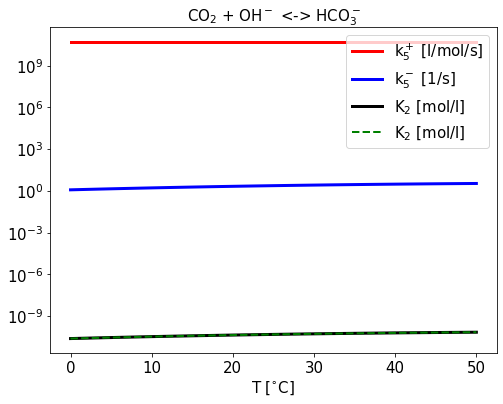

In [13]:
plt.figure(figsize=(8,6))
plt.title('CO$_2$ + OH$^-$ <-> HCO$_3^-$')
plt.xlabel('T [$^{\circ}$C]')
plt.semilogy(TC,k5pk5m(TC)[0],linewidth=3,color='red',linestyle='solid',label='k$_5^+$ [l/mol/s]')
plt.semilogy(TC,k5pk5m(TC)[1],linewidth=3,color='blue',linestyle='solid',label='k$_5^-$ [1/s]')
plt.semilogy(TC,k5pk5m(TC)[1]/k5pk5m(TC)[0],linewidth=3,color='black',linestyle='solid',label='K$_2$ [mol/l]')
plt.semilogy(TC,K1K2(TC)[1],linewidth=2,color='green',linestyle='dashed',label='K$_2$ [mol/l]')
plt.legend()
plt.savefig('figures/CHEM_K2_k5p_k5m')

In [14]:
def k6pk6m(TC,S=0):
    """
    -----------------------------------------------------------------------
    k6-,k6-  - dissociation of HCO3- in OH-
    HCO3- + OH- <-> CO3-- + H2O
    -----------------------------------------------------------------------
    Eigen (1964), after Schulz et al (2006): Determination of the rate 
    constants for the carbon dioxide to bicarbonate inter-conversion in 
    pH-buffered seawater systems, Mar. Chem., 100, 53-65
    input:
    TC [C]         - temperature
    S [permil]     - salinity
    output:
    k6+ [l/mol/s]  - (HCO3-) + (OH-) -> (CO3--) + (H2O)
    k6- [1/s]      - (HCO3-) + (OH-) <- (CO3--) + (H2O)
    k6m calculated from k6p*KW/K2
    """
    TK = 273.16 + TC
    k6p = 6e9*TK/TK
    k6m = k6p*KW(TC)/K1K2(TC)[1]
    return k6p,k6m

print('k6p(25C)= ',k6pk6m(25)[0])
print('k6m(25C)= ',k6pk6m(25)[1])

k6p(25C)=  6000000000.0
k6m(25C)=  1298572.1226437301


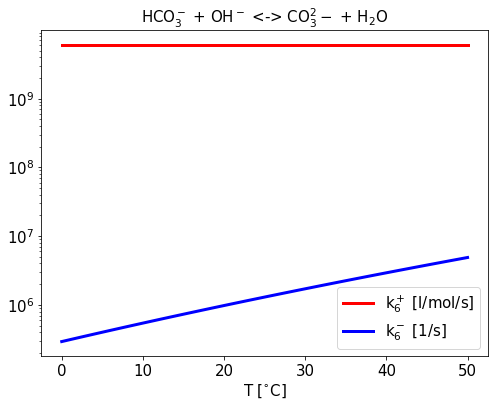

In [15]:
plt.figure(figsize=(8,6))
plt.title('HCO$_3^-$ + OH$^-$ <-> CO$_3^2-$ + H$_2$O')
plt.xlabel('T [$^{\circ}$C]')
plt.semilogy(TC,k6pk6m(TC)[0],linewidth=3,color='red',linestyle='solid',label='k$_6^+$ [l/mol/s]')
plt.semilogy(TC,k6pk6m(TC)[1],linewidth=3,color='blue',linestyle='solid',label='k$_6^-$ [1/s]')
plt.legend()

----
## Solving for species
Thus in a solution of water and carbon dioxide, the following components are present:
water H$_2$O,
hydrogen H$^+$,
hydroxyl OH$^-$,
carbon dioxide CO$_2$,
carbonic acid H$_2$CO$_3$,
bicarbonate HCO$_3^-$, and
carbonate CO$_3^{2-}$.

In [16]:
def KH(TC):
    """
    -----------------------------------------------------------------------
    KH - Henry constant (solubility of CO2 in water)
    KH = (CO2) / pCO2
    -----------------------------------------------------------------------
   Weiss, R. F., Marine Chemistry 2:203-215, 1974.
    input:
    TC [C]         - temperature
    output:
    KH [mol/l/atm] - CO2gas <-> CO2water
    """
    TK = 273.16 + TC
    KH =  -60.2409 + (93.4517 / (TK/100)) + (23.3585 * np.log((TK/100)))
    KH = np.exp(KH)
    return KH

In [17]:
def rhs(y,t,TC):
    """
    right-hand side of system of diff. equations
    input: old values y^(i-1)
    y[0] - CO2
    y[1] - HCO3-
    y[2] - CO32-
    y[3] - H+
    y[4] - OH-
    output: right-hand sides
    dydt[0] - dCO2/dt
    dydt[1] - dHCO3-/dt
    dydt[2] - dCO32-/dt
    dydt[3] - dH+/dt
    dydt[4] - dOH-/dt
    """
    # get rate constants and equilibrium constants for fixed temperature
    ka = 1.4e11           # l/mol/s
    kd = ka*KW(TC)                   # mol/l/s
    k1p,k1m = k1pk1m(TC)
    k4p,k4m = k4pk4m(TC)
    k5p,k5m = k5pk5m(TC)
    k6p,k6m = k6pk6m(TC)
    k6p=0.;k6m=0.
    #print(k1p,k1m)
    #print(k4p,k4m)
    #print(k5p,k5m)
    #print(k6p,k6m)
    # calculate right-hand sides
    dCO2     = +(k1m*y[3] + k4m)*y[1] - (k1p + k4p*y[4])*y[0]
    dHCO3m   = +(k1p + k4p*y[4])*y[0] - (k1m*y[3] + k4m)*y[1] + (k5p*y[3]+k6p)*y[2] - (k5m+k6m*y[4])*y[1]
    dCO32m   = +(k5m+k6p*y[4])*y[1] - (k5p*y[3]+k6m)*y[2]
    dHp      = +k1p*y[0] - k1m*y[3]*y[1] + k5m*y[1] - k5p*y[3]*y[2] + kd - ka*y[3]*y[4]
    dOHm     = +k4m*y[1] -k4p*y[4]*y[0] -k6p*y[4]*y[1] + k6m*y[2] + kd - ka*y[3]*y[4] 
    dydt = [dCO2,dHCO3m,dCO32m,dHp,dOHm]
    return dydt

In [18]:
TC = 25.
CO2ppm = 420
CO2water = KH(TC)*CO2ppm*1e-6

t = np.linspace(0,22,50000)
CO20   = CO2water
HCO3m0 = 0.
CO32m0 = 0.
Hp0    = 0.
OHm0   = 0.
y0   = [CO20,HCO3m0,CO32m0,Hp0,OHm0]
print(y0)
print(rhs(y0,t,TC))
#sol = scipy.integrate.odeint(rhs, y0, t, args=(TC,))

[1.4301805090754653e-05, 0.0, 0.0, 0.0, 0.0]
[-5.312061611714167e-07, 5.312061611714167e-07, 0.0, 0.0014189788285933094, 0.001418447622432138]


In [19]:
sol = scipy.integrate.odeint(rhs, y0, t, args=(TC,))

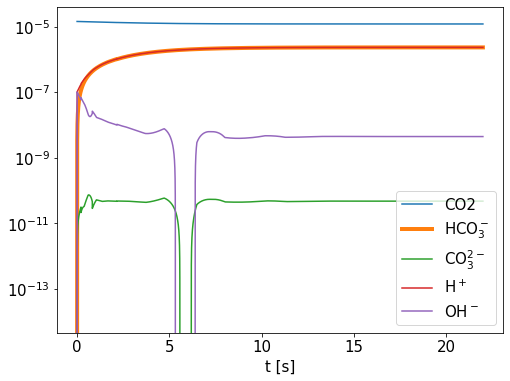

In [20]:
plt.figure(figsize=(8,6))
plt.xlabel('t [s]')
plt.semilogy(t,sol[:,0],label='CO2')
plt.semilogy(t,sol[:,1],linewidth=4,label='HCO$_3^-$')
plt.semilogy(t,sol[:,2],label='CO$_3^{2-}$')
plt.semilogy(t,sol[:,3],label='H$^+$')
plt.semilogy(t,sol[:,4],label='OH$^-$')
plt.legend()

/var/folders/2n/l4lbpz315tgd3w5k2mf_52v40000gn/T/ipykernel_4199/2796825305.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(t,-np.log10(sol[:,3]),label='H$^+$')


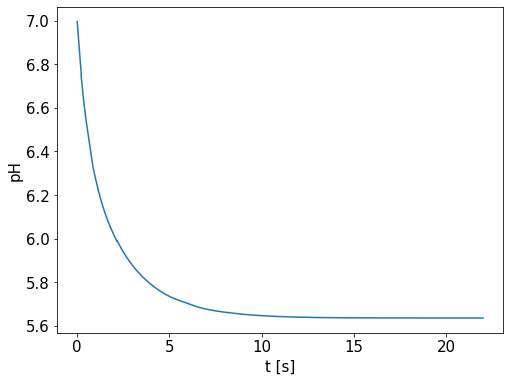

In [21]:
plt.figure(figsize=(8,6))
plt.xlabel('t [s]')
plt.ylabel('pH')
plt.plot(t,-np.log10(sol[:,3]),label='H$^+$')

----
## Literature

- Dreybrodt, Laukner, Svensson, Liu, Buhmann (1996). <br> **The kinetics of the reaction CO2 + H2O → H+ + HCO3− as one of the rate limiting steps for the dissolution of calcite in the system H2OCO2CaCO3**, Geochim. Cosmochim. Acta, 60(18):3375–3381
- Millero, Graham, Huang, Bustos-Serrano, Pierrot (2006). **Dissociation constants of carbonic acid in seawater as a function of salinity and temperature**,
Marine Chemistry 100(1-2):80-94.
- Schulz, Riebesell, Rost, Toms, Zeebe (2006): **Determination of the rate constants for the carbon dioxide to
bicarbonate inter-conversion in pH-buffered seawater systems**,
Marine Chemistry 100 (2006) 53–65.

----